## Installing Detectron and dependencies

## 1.0 Installing Detectron and dependencies

In [83]:
%%time

# Wall time: 5min 37s

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
MEGA_USER_PASS = user_secrets.get_secret("mega_pass")
MEGA_USER_EMAIL = user_secrets.get_secret("mega_user")

MEGA_FILES_AVAILBLE = ['Detectron2_Compressed_Env.zip', 'Detectron2_Env.zip']


def import_external_libraries(file_to_download = 'Detectron2_Compressed_Env.zip'):
    """
    Import External Libraries from Mega account
    """
    assert file_to_download in MEGA_FILES_AVAILBLE, "Choose file from MEGA_FILES_AVAILBLE list"

    import os, sys

    # 1. Install Mega libraries 
    !pip install mega.py
    from mega import Mega

    # 2. Create Mega object
    mega = Mega()
    
    # 3. Create Account object
    m_account = mega.login(MEGA_USER_EMAIL, MEGA_USER_PASS)

    # 4. set the path of our libraries
    imported_libs_path = f'./{file_to_download}'

    # 5. Locate file in the Mega repository
    file = m_account.find(file_to_download)

    # 6. Download the file to our machine
    m_account.download(file, './')

    # 7. unzip the file 
    !unzip -uq "$imported_libs_path" -d './' 

    
    
    # 8. Setup python to look for it's libraries in imported_libs_path. (-4: delete ".zip")
    print(imported_libs_path , imported_libs_path[:-4])
    sys.path.insert(0,"./Detectron2")
    # Add the nb_path to the global PATH variables, so python would search import in this folder first

    # 9. delete zip
    !rm "$imported_libs_path"

    return m_account

m_account = import_external_libraries()

./Detectron2_Compressed_Env.zip ./Detectron2_Compressed_Env
CPU times: user 5min 6s, sys: 4.27 s, total: 5min 10s
Wall time: 5min 25s


## 1.1 Modifying detectron's file

In [84]:
def over_write_file(fp_to_new_file, path_to_overwriteMe):
    
    # Copies the original file and overwrites the target file (hence -f which stands for "force").
    !cp -f "$fp_to_new_file" "$path_to_overwriteMe"


path_to_new_file = "../input/aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa/fast_rcnn.py"
DETECTRON2_ROOT = "./Detectron2/detectron2"
path_to_swapped_file = f"{DETECTRON2_ROOT}/modeling/roi_heads/fast_rcnn.py"

over_write_file(path_to_new_file, path_to_swapped_file)

In [85]:
# !pip install pyyaml==5.1

# # workaround: install old version of pytorch since detectron2 hasn't released packages for pytorch 1.9 (issue: https://github.com/facebookresearch/detectron2/issues/3158)
# !pip install torch==1.8.0+cu101 torchvision==0.9.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

# # install detectron2 that matches pytorch 1.8
# # See https://detectron2.readthedocs.io/tutorials/install.html for instructions
# !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# # exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

## 1.2 Imports

In [86]:
import collections
import torch
import json
import os
import cv2
import random
import gc # garbage collector
import pycocotools
import torch.nn.functional as F

import numpy as np 
import pandas as pd 
from tqdm import tqdm
import matplotlib.pyplot as plt
import PIL
from PIL import Image, ImageFile
from torch.utils.data import Dataset, DataLoader

from pathlib import Path

# import some common detectron2 utilities
from detectron2.structures import BoxMode
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

## 1.3 Checking Device

In [87]:
import torch
## Selecting device GPU OR CPU 
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [88]:
# see GPU allocated
!nvidia-smi

Sun Aug  1 06:28:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    33W / 250W |   2401MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 1.4 Github I/O

In [89]:
import os
import pickle
from pathlib import Path
from datetime import datetime
from datetime import date
import random
from sklearn.model_selection import train_test_split
# https://stackoverflow.com/questions/48350226/methods-for-using-git-with-google-colab

now = datetime.now()
current_time = now.strftime("%H:%M:%S")



# Setup Constants
GIT_USER_NAME = 'Shahar Raz'
GIT_USER_EMAIL = 'SRazStudent@gmail.com'

GIT_NEW_BRANCH_NAME = f'{GIT_USER_NAME}, {date.today()} at {current_time}'
GIT_DEFAULT_BRANCH_NAME = 'main'

GIT_DEFAULT_MESSAGE = f'{GIT_USER_NAME}, {date.today()} at {current_time}'

GIT_KEYPOINTS_DIR = '/content/CV2021/Keypoints_GPU/'

!git init


def importFilesFromGithub(branch_name = 'main', import_folders = [], new_dir_name = "CV2021" ):
    """returns the directory in-which we'll save the files
        Note: if import_folders is empty, the repo will be donwloaded entirly
    """

    # if not already imported
    if not Path(f"/content/{new_dir_name}").exists(): 

        # 1. Create new local directory
        ! mkdir "$new_dir_name"/

        # 2. Stepping into the folder
        %cd "$new_dir_name"/

        # 3. Init git repo
        !git init

        # 4. Add the github remote (with id key)
        ! git remote add "$new_dir_name"Github https://github.com/ShahaRaz/ComputerVision2021B.git

        # 5. Select specific subfolders to download
        if len(import_folders) > 0:
            # a. Enable Sparse Checkouts (Opposite of gitIgnore)
            ! git config core.sparsecheckout true
            # b. Tell Git which directories you want
            for folder in import_folders:
                ! echo "$folder" >> .git/info/sparse-checkout
            

        # 6. pulling project to local dir
        ! git pull "$new_dir_name"Github "$branch_name";

    return f'/content/{new_dir_name}'


def saveFilesToGithub(message_of_commit,branch_name = GIT_DEFAULT_BRANCH_NAME, user_name = 'Shahar ColabRnnLstm', user_email = 'SRazStudent@gmail.com'):
    def setLocalID():
        # adding my name
        !git config --global user.name  "$user_name"   #"Shahar ColabRnnLstm "
        !git config --global user.email "$user_email"  #"SRazStudent@gmail.com"
        #__ changing use name: __
        # !git config --global --unset user.name
        # !git config --global user.name  "Shahar ModifiedName "
                        # list configs
                        # !git config -l

    setLocalID()

    # create new branch
    !git checkout -b "$branch_name"
        
    # add files to commit
    %cd /content/CV2021/

    !git add -A   

    #back to home directory
    %cd ~/content/
    # !git add /content/CV2021/*
                    # #checking the status
                    # !git status


    # Commit all Changes
    !git commit -a -m "$message_of_commit" #"delete meee"

    # Push to remote
    !git push CV2021Github "$branch_name" #master



# Don't use me unless realy realy needed
# def resetToSpecificVersion(version_number = 'e63126e0f5aca7db3f087aa34b640a904b5ffd71'):
#     !git reset "$version_number" --hard






# directory = importFilesFromGithub()

# saveFilesToGithub(f'Adding {current_song}\'s predPoints')



Initialized empty Git repository in /kaggle/working/.git/


## 1.5 setup constants

In [90]:
N_OF_EXAMPLES_IN_DF = 250 # used in section 3.2
NaNs_REPLACEMENT = 999 # Used in section 3.3 ## TODO: Check if it is what it really means..
N_OF_PICS_IN_FASHION_DICT = 50 # Used in section 3.4

N_OF_SAMPLES_IN_DF_COPY_TRAIN = 500 # Used in 4.1
N_OF_SAMPLES_IN_DF_COPY_TEST = 200 # Used in 4.1

# 2. Exploration of data

In [91]:
data_dir = Path('/kaggle/input/imaterialist-fashion-2020-fgvc7/') # general
image_dir = Path('/kaggle/input/imaterialist-fashion-2020-fgvc7/train/') # all train pictures
test_dir = Path('/kaggle/input/imaterialist-fashion-2020-fgvc7/test/')# test path: 

# read train df,
# df = pd.read_csv(data_dir/'train.csv')



# Get label descriptions
with open(data_dir/'label_descriptions.json', 'r') as file:
    label_desc = json.load(file)
df_categories = pd.DataFrame(label_desc['categories'])
df_attributes = pd.DataFrame(label_desc['attributes'])
gc.collect()

28

In [92]:
gc.collect()

22

In [93]:
# print(f'Segments that do not have attributes: {df["AttributesIds"].isna().sum()/len(df) * 100} %')

## 2.1 Image Examples w/ Pretrained Instance Segmentation

### 2.1.1 Setup Detectron2's Predictor:

In [95]:
# Detectron2's configurtaion file
cfg = get_cfg()

# Merging model configs with default 
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

# Setup detection thresh-hold
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.ROI_HEADS.NUM_ATTRIBUTES = 293
# Get weights from Instance segmentation Mask RCNN R 50 FPN model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

predictor = DefaultPredictor(cfg)

model_final_f10217.pkl: 178MB [00:08, 21.5MB/s]                              


Image Examples with pretrained Instance Segmentation

### 2.1.2 Fetch Images

In [96]:
# Fetch Train Images
images_list = []
for dirname, _, filenames in os.walk('/kaggle/input/imaterialist-fashion-2020-fgvc7/train/'):
    for filename in filenames:
        # Save paths of images to ram (not images, inorder to avoid filling up the RAM)
        images_list.append(os.path.join(dirname, filename))

### 2.1.3 Plot Examples

INFERENCE cls 1 torch.Size([1000, 81])
INFERENCE attr 1 torch.Size([1000, 294])
INFERENCE cls 2 torch.Size([1000, 81])
INFERENCE attr 2 torch.Size([1000, 294])
INFERENCE cls 3 torch.Size([1000, 80])
INFERENCE attr 3 torch.Size([1000, 293])
INFERENCE cls 4 torch.Size([1000, 80])
INFERENCE attr 4 torch.Size([1000, 293])
INFERENCE cls mask 4 torch.Size([1000, 80])
INFERENCE attr mask 4 torch.Size([1000, 293])


IndexError: index is out of bounds for dimension with size 0

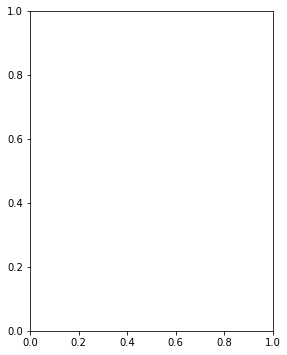

In [97]:
## Uncomment me b4 submission
# Plot Images in 3x4 grid
# Show different images at random
rows, cols = 3, 4
plt.figure(figsize=(20,20))

for i, image in enumerate(random.sample(images_list, rows*cols)):
    
    # Process image
    im = cv2.imread(image)
    plt.subplot(rows, cols, i+1)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    
    # Run through predictor
    outputs = predictor(im)
    
    
    # Visualize
    
    # https://stackoverflow.com/questions/53716324/what-does-1-mean-in-python
    # ::-1 means "take everything in this dimension but backwards." : [ RGB <-> BGR ]
    v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.axis('off')
    plt.imshow(v.get_image()[:, :, ::-1])
    
    

plt.show()

## 2.2 Image Examples with Keypoint Detection 

What Keypoints??? Skeletons are not in images, Checked in original notebook.. it doesn't show there too

### 2.2.1 Setup Detectron2's Predictor:

In [98]:
# Reset Detectron2's Configuration
cfg = get_cfg()

cfg.merge_from_file(model_zoo.get_config_file("Misc/cascade_mask_rcnn_R_50_FPN_1x.yaml"))

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.ROI_HEADS.NUM_ATTRIBUTES = 293

# Get weights from Keypoint Mask RCNN R 50 FPN model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("Misc/cascade_mask_rcnn_R_50_FPN_1x.yaml")

predictor = DefaultPredictor(cfg)
gc.collect()

model_final_e9d89b.pkl: 288MB [00:22, 12.6MB/s]                              


6456

### 2.2.2 Plot Examples

TypeError: fast_rcnn_inference() missing 1 required positional argument: 'topk_per_image'

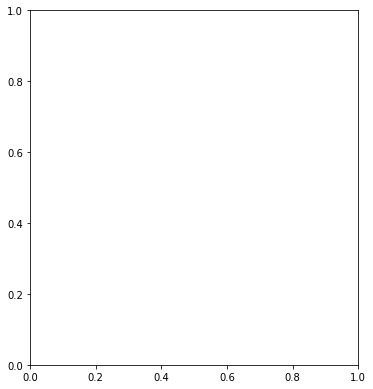

In [99]:
## Uncomment me b4 submission
# Show different images at random
rows, cols = 3, 4
plt.figure(figsize=(20,30))

for i, image in enumerate(random.sample(images_list, rows*cols)):
    
    # Process image
    im = cv2.imread(image)
    plt.subplot(cols, rows, i+1)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    
    # Run through predictor
    outputs = predictor(im)
    
    # Visualize
    v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.axis('off')
    plt.imshow(v.get_image()[:, :, ::-1])

plt.show()
gc.collect()

## 2.3 show class distribution

In [133]:
df = pd.read_csv(data_dir/'train.csv')

5650

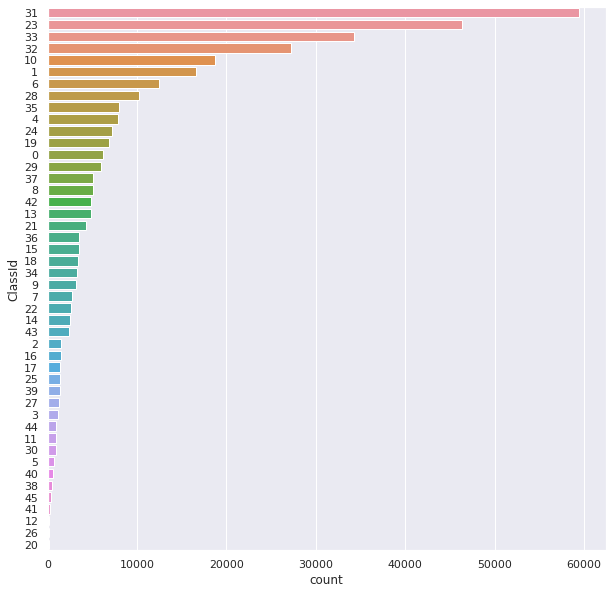

In [134]:
import seaborn as sns

sns.set(style='darkgrid')
fig, ax = plt.subplots(figsize = (10,10))
sns.countplot(y='ClassId',data=df , ax=ax, order = df['ClassId'].value_counts().index)
fig.show()
gc.collect()

31 = sleeves, 23 = shoes,


make sense since most photos has 2 sleeves and 2 shoes in them

20 = leg warmer: NOBODY uses this very fashionable accessory 

[]

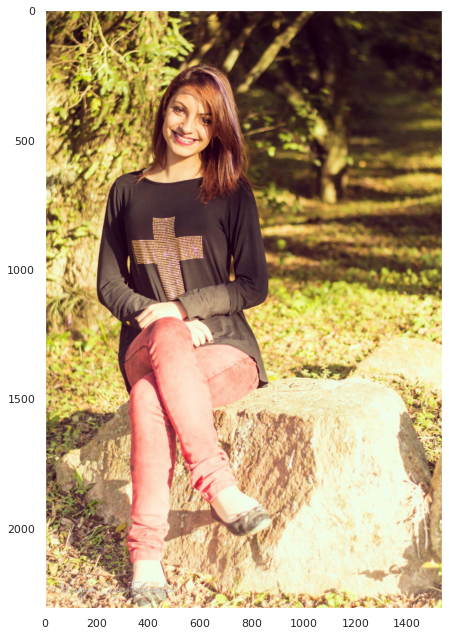

In [135]:
import matplotlib.image as mpimg

IMAGE_ID = '000b3ec2c6eaffb491a5abb72c2e3e26'
# Get the an image id given in the training set for visualization
vis_df = df[df['ImageId'] == IMAGE_ID]
vis_df = vis_df.reset_index(drop=True)
vis_df
plt.figure(figsize = (110,11))
image = mpimg.imread(f'/kaggle/input/imaterialist-fashion-2020-fgvc7/train/{IMAGE_ID}.jpg')
plt.grid(False)
plt.imshow(image)
plt.plot()

In [136]:
segments = list(vis_df['EncodedPixels'])
class_ids = list(vis_df['ClassId'])
masks = []
for segment, class_id in zip(segments, class_ids):
    
    height = vis_df['Height'][0]
    width = vis_df['Width'][0]
    # Initialize empty mask
    mask = np.zeros((height, width)).reshape(-1)
    
    # Iterate over encoded pixels and create mask
    splitted_pixels = list(map(int, segment.split()))
    pixel_starts = splitted_pixels[::2]
    run_lengths = splitted_pixels[1::2]
    assert max(pixel_starts) < mask.shape[0]
    for pixel_start, run_length in zip(pixel_starts, run_lengths):
        pixel_start = int(pixel_start) - 1
        run_length = int(run_length)
        mask[pixel_start:pixel_start+run_length] = 255 - class_id * 4

    mask = mask.reshape((height, width), order='F')
    masks.append((mask, class_id))

def plot_individual_segment(*masks, image, figsize=(110, 11)):
    plt.figure(figsize = figsize)
    plt.imshow(image)
    for mask in masks:
        plt.title(next(iter(df_categories[df_categories['id'] == mask[1]]['name']), 'no match'))
        plt.imshow(mask[0], alpha=0.6)
        print(mask[1])
    plt.axis('off')
    plt.show()
gc.collect()

2932

23


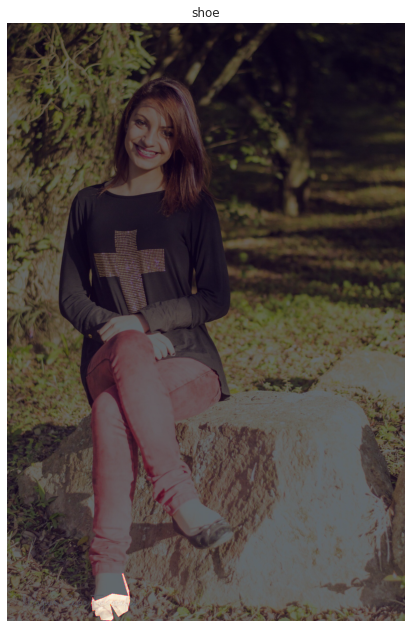

23


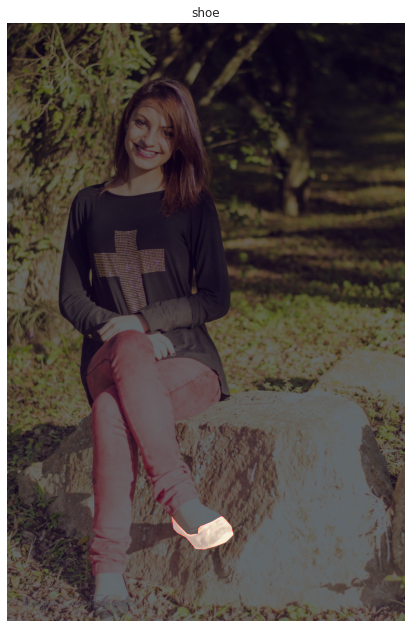

6


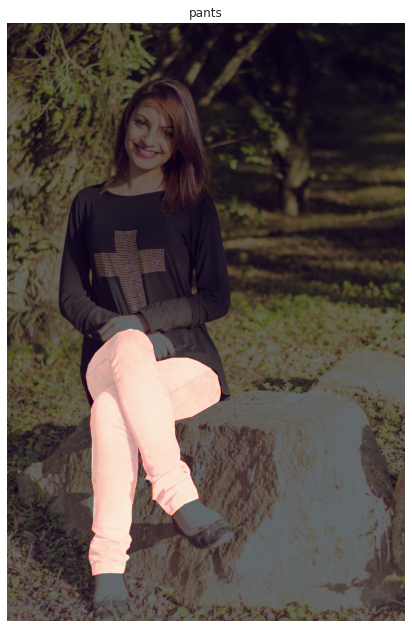

1


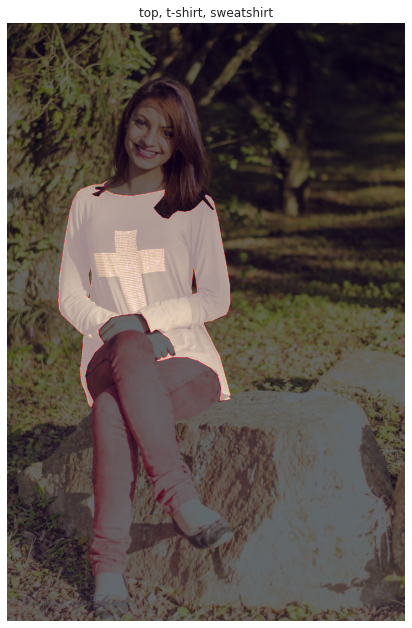

32


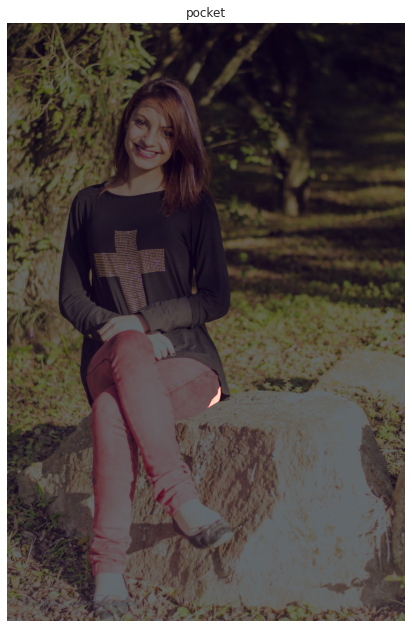

31


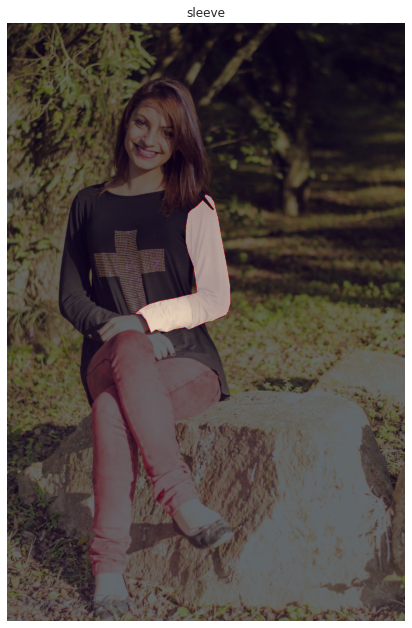

31


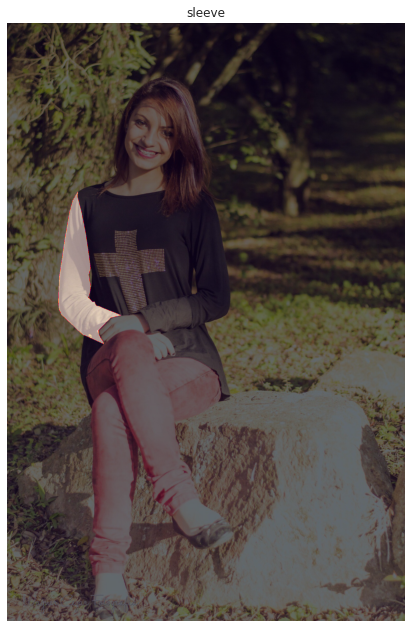

33


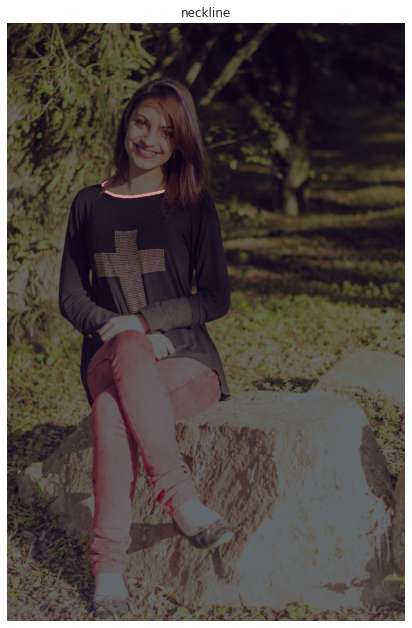

21296

In [137]:
## Uncomment me b4 submission
for i in range(8):
    plot_individual_segment(masks[i], image=image)
gc.collect()

In [138]:
# Lets see how many Segments we have without attributes
print(f'Segments that do not have attributes: {df["AttributesIds"].isna().sum()/len(df) * 100} %')

Segments that do not have attributes: 38.089567817733 %


## 2.4 Show multiple classes within multiple images

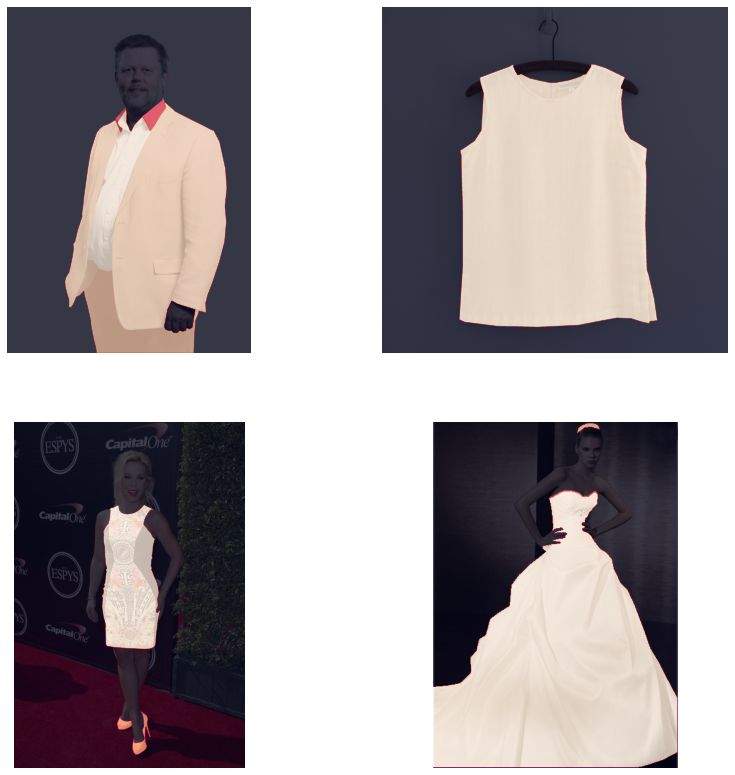

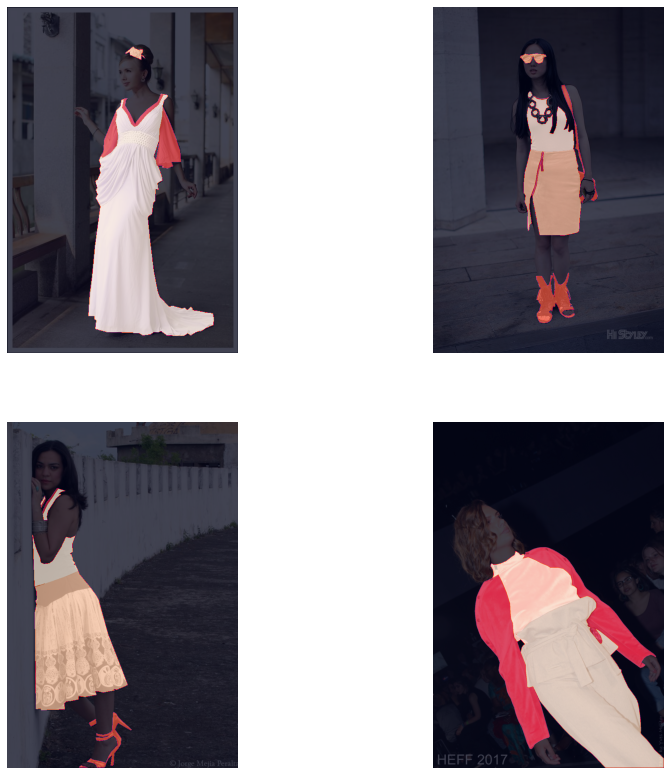

9266

In [139]:
## Uncomment me b4 submission

import matplotlib.image as mpimg

def create_mask(size, train_df):
    image_ids = train_df['ImageId'].unique()[:size]
    images_meta=[]

    for image_id in image_ids:
        img = mpimg.imread(f'/kaggle/input/imaterialist-fashion-2020-fgvc7/train/{image_id}.jpg')
        images_meta.append({
            'image': img,
            'shape': img.shape,
            'encoded_pixels': train_df[train_df['ImageId'] == image_id]['EncodedPixels'],
            'class_ids':  train_df[train_df['ImageId'] == image_id]['ClassId']
        })

    masks = []
    for image in images_meta: 
        shape = image.get('shape')
        encoded_pixels = list(image.get('encoded_pixels'))
        class_ids = list(image.get('class_ids'))
        
        # Initialize numpy array with shape same as image size
        height, width = shape[:2]
        mask = np.zeros((height, width)).reshape(-1)
        
        # Iterate over encoded pixels and create mask
        for segment, (pixel_str, class_id) in enumerate(zip(encoded_pixels, class_ids)):
            splitted_pixels = list(map(int, pixel_str.split()))
            pixel_starts = splitted_pixels[::2]
            run_lengths = splitted_pixels[1::2]
            assert max(pixel_starts) < mask.shape[0]
            for pixel_start, run_length in zip(pixel_starts, run_lengths):
                pixel_start = int(pixel_start) - 1
                run_length = int(run_length)
                mask[pixel_start:pixel_start+run_length] = 255 - class_id * 4
        masks.append(mask.reshape((height, width), order='F'))  # https://stackoverflow.com/questions/45973722/how-does-numpy-reshape-with-order-f-work
    return masks, images_meta

def plot_segmented_images(size=8, figsize=(14, 14)):
    # First create masks from given segments
    masks, images_meta = create_mask(size, df)
    
    # Plot images in groups of 4 images
    n_groups = 4
    
    count = 0
    for index in range(size // 4):
        fig, ax = plt.subplots(nrows=2, ncols=2, figsize=figsize)
        for row in ax:
            for col in row:
                col.imshow(images_meta[count]['image'])
                col.imshow(masks[count], alpha=0.75)
                col.axis('off')
                count += 1
        plt.show()
    gc.collect()

plot_segmented_images()
gc.collect()

# 3. Create Dataset

## 3.? COCO Format

### 3.2.1 Rle Helper Functions

[Coco Dataset Format & Rle Explained](https://www.youtube.com/watch?v=h6s61a_pqfM&ab_channel=ImmersiveLimit)

In [140]:
# Rle helper functions

def rle_decode_string(string, h, w):
    # Creating Mask of 1's on crowded areas (RLE) 
    mask = np.full(h*w, 0, dtype=np.uint8)
    annotation = [int(x) for x in string.split(' ')]
    for i, start_pixel in enumerate(annotation[::2]):
        mask[start_pixel: start_pixel+annotation[2*i+1]] = 1
    mask = mask.reshape((h, w), order='F')

    
    return mask

def rle2bbox(rle, shape):
    '''
    Get a bbox from a mask which is required for Detectron 2 dataset
    rle: run-length encoded image mask, as string
    shape: (height, width) of image on which RLE was produced
    Returns (x0, y0, x1, y1) tuple describing the bounding box of the rle mask
    
    Note on image vs np.array dimensions:
    
        np.array implies the `[y, x]` indexing order in terms of image dimensions,
        so the variable on `shape[0]` is `y`, and the variable on the `shape[1]` is `x`,
        hence the result would be correct (x0,y0,x1,y1) in terms of image dimensions
        for RLE-encoded indices of np.array (which are produced by widely used kernels
        and are used in most kaggle competitions datasets)
    '''
    
    a = np.fromiter(rle.split(), dtype=np.uint)
    a = a.reshape((-1, 2))  # an array of (start, length) pairs
    a[:,0] -= 1  # `start` is 1-indexed
    
    y0 = a[:,0] % shape[0]
    y1 = y0 + a[:,1]
    if np.any(y1 > shape[0]):
        # got `y` overrun, meaning that there are a pixels in mask on 0 and shape[0] position
        y0 = 0
        y1 = shape[0]
    else:
        y0 = np.min(y0)
        y1 = np.max(y1)
    
    x0 = a[:,0] // shape[0]
    x1 = (a[:,0] + a[:,1]) // shape[0]
    x0 = np.min(x0)
    x1 = np.max(x1)
    
    if x1 > shape[1]:
        # just went out of the image dimensions
        raise ValueError("invalid RLE or image dimensions: x1=%d > shape[1]=%d" % (
            x1, shape[1]
        ))

    return x0, y0, x1, y1



def mask_to_rle(mask):
    pixels = mask.T.flatten()
    # We need to allow for cases where there is a '1' at either end of the sequence.
    # We do this by padding with a zero at each end when needed.
    use_padding = False
    if pixels[0] or pixels[-1]:
        use_padding = True
        pixel_padded = np.zeros([len(pixels) + 2], dtype=pixels.dtype)
        pixel_padded[1:-1] = pixels
        pixels = pixel_padded
    rle = np.where(pixels[1:] != pixels[:-1])[0] + 2
    if use_padding:
        rle = rle - 1
    rle[1::2] = rle[1::2] - rle[:-1:2]
    return ' '.join(str(x) for x in rle)


from itertools import groupby

def binary_mask_to_rle(binary_mask):
    rle = {'counts': [], 'size': list(binary_mask.shape)}
    counts = rle.get('counts')

    last_elem = 0
    running_length = 0

    for i, elem in enumerate(binary_mask.ravel(order='F')):
        if elem == last_elem:
            pass
        else:
            counts.append(running_length)
            running_length = 0
            last_elem = elem
        running_length += 1

    counts.append(running_length)

    return rle



## 3.3 Creating df_copy

(TODO: Add a drawing that describes the dataset's formation)

In [141]:
image_dir

PosixPath('/kaggle/input/imaterialist-fashion-2020-fgvc7/train')

In [142]:
# # Get image file path and add it to our dataframe
# dirname = str(image_dir)
# print(dirname)

# # Get only first N_OF_EXAMPLES_IN_DF
# # df_copy = df[:N_OF_EXAMPLES_IN_DF].copy() # Take only first 4000 images
# df_copy = df.copy() #.sample(n=N_OF_EXAMPLES_IN_DF).copy()

# # Take only the rows that has attributes 
# print(f'Segments that do not have attributes: {df["AttributesIds"].isna().sum()/len(df) * 100} %')
# df_copy = df[~df['AttributesIds'].isnull()].copy(deep = True)
# print(len(df_copy)/len(df)) # how much of the dataframe were taking





# # setup ImageId to be the full path to the photo. # TODO: Check why coping
# df_copy['ImageId'] = dirname + '/' + df_copy['ImageId'] + '.jpg'

# gc.collect()

### 3.3.1 extracting bboxes for each mask

In [143]:
# # Get bboxes for each mask
# # bboxes = [rle2bbox(c.EncodedPixels, (c.Height, c.Width)) for n, c in df_copy.iterrows()]


# # Extending this line:
# bboxes = []
# for n,c in df_copy.iterrows():
#     bboxes.append(rle2bbox(c.EncodedPixels, (c.Height, c.Width)))

In [144]:
# assert len(bboxes) == df_copy.shape[0]

In [145]:
# Convert to numpy array
# bboxes_array = np.array(bboxes)

In [146]:
# Add each coordinate as a column
# df_copy['x0'], df_copy['y0'], df_copy['x1'], df_copy['y1'] = bboxes_array[:,0], bboxes_array[:,1], bboxes_array[:,2], bboxes_array[:,3]

In [147]:
# why 999? what does it represents?
# df_copy.head()

In [148]:
#Replace NaNs from AttributeIds by -1
# df_copy = df_copy.fillna(999)

In [149]:
# # Free spaces of bounding boxes (we already have df_copy which is made of it..)
# del bboxes

# # Free space of df
# del df

# # Garbage Collector 
# gc.collect()

### 3.3.2 AtterbiutIds -> [String -> List]

In [150]:
# def get_max_attributesIds_len(df):
#     counter = 1
#     max_len = 0
#     for col in df["AttributesIds"]:

#         col = str(col)
#         splitted = col.split(",")
#         a = len(splitted)
#         if max_len < a:
#             max_len = a

#     return max_len

# max_atr_len = get_max_attributesIds_len(df_copy) # 14
# print(f'in the "worst case" our len is __ {max_atr_len} __ , so we will set all tensors to this len')

In [151]:
# # Error:
# # SettingWithCopyWarning: A value is trying to be set on a copy of a
# # slice from a DataFrame

# # As explained in the Source, this warning is usually safe to ignore. You
# # can disable it by running the following:

# import pandas as pd
# pd.options.mode.chained_assignment = None  # default='warn'



# # Extremely ugly function - need to refactor
# def attr_str_to_list(df):
#     '''
#     Function that transforms DataFrame AttributeIds which are of type string into a 
#     list of integers. Strings must be converted because they cannot be transformed into Tensors
#     '''
#     # cycle through all the non NaN rows - NaN causes an error
#     for index, row in df.iterrows(): # O(n)
        
#         # Treating str differently than int
#         if isinstance(row['AttributesIds'], str):
            
#             # Convert each row's string into a list of strings             
#             df['AttributesIds'][index] = row['AttributesIds'].split(',')
            
#             # Convert each string in the list to int
#             df['AttributesIds'][index] = [int(x) for x in df['AttributesIds'][index]] # maximum 14 times
            
#         # If int (no attribute inspected) - make it a list of length 1
#         if isinstance(row['AttributesIds'], int):
#             df['AttributesIds'][index] = [999]
            
#         # Convert list to array
#         df['AttributesIds'][index] = np.array(df['AttributesIds'][index])

#         # Pad array with 0's so that all arrays are the same length - This will allows us to convert to tensor
#         df['AttributesIds'][index] = np.pad(df['AttributesIds'][index], (0, max_atr_len - len(df['AttributesIds'][index]))) 

        
# attr_str_to_list(df_copy)
# gc.collect()

In [152]:
# # Debugging: 
# print(cfg.dump())

### 3.3.3 File df

In [153]:
# Save dataset to file
# import pickle

# file_name = 'final_dataframe.enough'

# with open(file_name, "wb") as file_pointer:
#     pickle.dump(df_copy, file_pointer)


In [154]:
# get dataset from file
import pickle

file_name = '../input/complete-dataframe-with-fixes/final_dataframe.enough'

with open(file_name, "rb") as file_pointer:
    df_copy = pickle.load(file_pointer)

## 3.4 Creating fashion_dict

Create Detectron2 dataset dict (also fetching attributes) 

TODO: Maybe Reduce the redundent work in stage 3.3.2 (I think that df_copy is a redundent dataframe that doesnt help anywhere..)

<img width="844" alt="image" src="https://user-images.githubusercontent.com/55464049/123538101-b5ea3700-d73b-11eb-88f6-c94dc93308bd.png">


In [155]:
from tqdm import tqdm

def get_fashion_dict(df):

    grps = df['ImageId'].unique().tolist()
    # put all annotations of an image one after another (grouping)
    dfg = df.groupby('ImageId')
    dataset_dicts = []
    # go over each photo (unique since each photo may have multiple annotations)
    for idx, filename in enumerate(tqdm(grps)):
        grup = dfg.get_group(filename)
        record = {}
        # Convert Height & Width to int otherwise evaluation will throw an error
        record['height'] = grup['Height'].values[0]
        record['width'] = grup['Width'].values[0]
        record['file_name'] = filename
        record['image_id'] = idx

        objs = []
        for row in grup.itertuples():
            # Create binary mask from EncodedPixel, Heigh, and Width columns
            mask = rle_decode_string(row[2], row[3], row[4])

            # transform the mask from binary to polygon
            contours, hierarchy = cv2.findContours((mask).astype(np.uint8), cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
            segmentation = []

            for contour in contours:
                contour = contour.flatten().tolist()
                if len(contour) > 4:
                    segmentation.append(contour)    

            obj = {
                'bbox': [row[7], row[8], row[9], row[10]],
                'bbox_mode': BoxMode.XYXY_ABS,
                'category_id': row[5],
                'attributes': [int(i in row[6]) for i in range(295)],
                'segmentation': segmentation, # polygon mask, as required by Detectron2 documentation
                'iscrowd': 0 #  (BUT SINCE RLE SHOULD BE1........)
            }
            objs.append(obj)
        record['annotations'] = objs
        dataset_dicts.append(record)
    return dataset_dicts




################# __ ORIGINAL CODE __ #################

# # https://detectron2.readthedocs.io/tutorials/datasets.html
# # https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5

# from detectron2.structures import BoxMode
# import pycocotools

# def get_fashion_dict(df):
    
#     dataset_dicts = []
#     # go over each photo (unique since each photo may have multiple annotations)
#     for idx, filename in enumerate(df['ImageId'].unique().tolist()):
        
#         record = {}
        
#         # Convert Height & Width to int otherwise evaluation will throw an error
#         record['height'] = int(df[df['ImageId']==filename]['Height'].values[0])
#         record['width'] = int(df[df['ImageId']==filename]['Width'].values[0])
        
#         record['file_name'] = filename
#         record['image_id'] = idx
        
# #         print('hey')
#         objs = []
#         # Fetch all Annotations for our image
#         # For each annotation over crurrent image
#         for index, row in df[(df['ImageId']==filename)].iterrows():
            
#             # Get binary mask
#             mask = rle_decode_string(row['EncodedPixels'], row['Height'], row['Width'])
            
            
    
#             # Transform Binary Mask To Polygon Format 
        
#             # opencv 4.2+
#             contours, hierarchy = cv2.findContours((mask).astype(np.uint8), cv2.RETR_TREE,
#                                                     cv2.CHAIN_APPROX_SIMPLE)
            
#             # opencv 3.2
#             # mask_new, contours, hierarchy = cv2.findContours((mask).astype(np.uint8), cv2.RETR_TREE,
#             #                                            cv2.CHAIN_APPROX_SIMPLE)
            
#             segmentation = []

#             for contour in contours:
#                 contour = contour.flatten().tolist()
#                 # segmentation.append(contour)
#                 if len(contour) > 4:
#                     # Format of contors???? 
#                     segmentation.append(contour)    
            
#             # Data for each mask
#             obj = {

#                 'bbox': [row['x0'], row['y0'], row['x1'], row['y1']],
#                 'bbox_mode': BoxMode.XYXY_ABS,
#                 'category_id': row['ClassId'],
#                 'attributes': row['AttributesIds'],
#                 'segmentation': segmentation,
#                 'iscrowd': 0
#             }
#             objs.append(obj)
#         record['annotations'] = objs
#         dataset_dicts.append(record)
#     return dataset_dicts

In [156]:
# To view a sample of fashion_dict
fashion_dict = get_fashion_dict(df_copy[:N_OF_PICS_IN_FASHION_DICT])
gc.collect()

100%|██████████| 14/14 [00:01<00:00,  8.46it/s]


289

By this stage we have __Array__ Called fashion_dicts,

inwhich each object represents a single image, with all it's annotations in polygon format 

## 3.5 Attribute holder class 

TODO: Create Drawing of Data Structure

In [ ]:
print(f'in the "worst case" the number of attributes for single annotation is __ {get_max_attributesIds_len(df_copy)} __ , so we will set all tensors to this len')

Fashion_Dict object (Single Image with many annotations) Example:

![image](https://user-images.githubusercontent.com/55464049/125260298-e10e8200-e308-11eb-9471-648d0962cc8c.png)

In [158]:
from typing import Iterator, List, Tuple, Union
import torch.nn.functional as F

# Base Attribute holder
class Attributes:
    """
    This structure stores a list of attributes as a Nx14 torch.Tensor (14 because we added a padding of 14 to all our attributes
    so that they can have the same length.
    It behaves like a Tensor
    (support indexing, `to(device)`, `.device`, `non empty`, and iteration over all attributes)
    """
    
    def __init__(self, tensor: torch.Tensor):
        """
        Args:
            tensor (Tensor[float]): a Nx13 matrix.  Each row is [attribute_1, attribute_2, ...].
        """
        device = tensor.device if isinstance(tensor, torch.Tensor) else torch.device("cpu")
        tensor = torch.as_tensor(tensor, dtype=torch.int64, device=device)
        # what does the tensor.size() means??? thats what it will print if dim is not good! 
        assert tensor.dim() == 2, tensor.size()
        self.tensor = tensor


    def __getitem__(self, item: Union[int, slice, torch.BoolTensor]) -> "Boxes":
        """
        Returns:
            Attributes: Create a new :class:`Attributes` by indexing.
        The following usage are allowed:
        1. `new_attributes = attributes[3]`: return a `Attributes` which contains only one Attribute.
        2. `new_attributes = attributes[2:10]`: return a slice of attributes.
        3. `new_attributes = attributes[vector]`, where vector is a torch.BoolTensor
           with `length = len(attributes)`. Nonzero elements in the vector will be selected.
        Note that the returned Attributes might share storage with this Attributes,
        subject to Pytorch's indexing semantics.
        """
        
        b = self.tensor[item]
        assert b.dim() == 2, "Indexing on Attributes with {} failed to return a matrix!".format(item)
        return Attributes(b)

    def __len__(self) -> int:
        return self.tensor.shape[0]
    
    def to(self, device: str) -> "Attributes":
        return Attributes(self.tensor.to(device))


    def nonempty(self, threshold: float = 0.0) -> torch.Tensor:
        """
        Find attributes that are non-empty.
        An attribute is considered empty if its first attribute in the list is 999.
        Returns:
            Tensor:
                a binary vector which represents whether each attribute is empty
                (False) or non-empty (True).
        """
        attributes = self.tensor
        first_attr = attributes[:, 0]
        keep = (first_attr != 999)
        return keep

    def __repr__(self) -> str:
        return "Attributes(" + str(self.tensor) + ")"


    def remove_padding(self, attribute):
        'WIP'
        pass

    @property
    def device(self) -> torch.device:
        return self.tensor.device

    def __iter__(self) -> Iterator[torch.Tensor]:
        """
        Yield attributes as a Tensor of shape (14,) at a time.
        """
        yield from self.tensor

# 4. Custom Trainer

## 4.1 Custom DatasetMapper
TODO: Create Drawing / explain it clearly somehow..

In [159]:
import copy
from detectron2.data import build_detection_train_loader, build_detection_test_loader
from detectron2.data import transforms as T
from detectron2.data import detection_utils as utils


class DatasetMapper:
    """
    A callable which takes a dataset dict in Detectron2 Dataset format,
    and map it into a format used by the model.

    This is a custom version of the DatasetMapper. The only different with Detectron2's 
    DatasetMapper is that we extract attributes from our photo_dict. 
    """

    def __init__(self, cfg, is_train=True):
        ## if training: crop
        if cfg.INPUT.CROP.ENABLED and is_train:
            self.crop_gen = T.RandomCrop(cfg.INPUT.CROP.TYPE, cfg.INPUT.CROP.SIZE)
            logging.getLogger(__name__).info("CropGen used in training: " + str(self.crop_gen))
        else:
            self.crop_gen = None

        ## ???
        self.tfm_gens = utils.build_transform_gen(cfg, is_train)

        # fmt: off ??? format?? 
        self.img_format     = cfg.INPUT.FORMAT
        self.mask_on        = cfg.MODEL.MASK_ON
        self.mask_format    = cfg.INPUT.MASK_FORMAT
        self.keypoint_on    = cfg.MODEL.KEYPOINT_ON
        self.load_proposals = cfg.MODEL.LOAD_PROPOSALS
        # fmt: on
        
        
        # Horizontal flipping? 
        if self.keypoint_on and is_train:
            # Flip only makes sense in training (Only creating this augmentation, not using it yet..)
            self.keypoint_hflip_indices = utils.create_keypoint_hflip_indices(cfg.DATASETS.TRAIN)
        else:
            self.keypoint_hflip_indices = None

        # Load proposals ( Region Proposoals )
        if self.load_proposals:
            # Minimum (highet or length)
            self.min_box_side_len = cfg.MODEL.PROPOSAL_GENERATOR.MIN_SIZE
            self.proposal_topk = (
                cfg.DATASETS.PRECOMPUTED_PROPOSAL_TOPK_TRAIN
                if is_train
                else cfg.DATASETS.PRECOMPUTED_PROPOSAL_TOPK_TEST
            )
        self.is_train = is_train

    def __call__(self, photo_dict): 
        """
        Args:
            photo_dict (dict): Metadata of one image, in Detectron2 Dataset format.

        Returns:
            dict: a format that builtin models in detectron2 accept
        """
        # Creating a deep copy, so we wont modify it
        photo_dict = copy.deepcopy(photo_dict)  # it will be modified by code below
        # USER: Write your own image loading if it's not from a file
        image = utils.read_image(photo_dict["file_name"], format=self.img_format)
        #Raise an error if the image does not match the size specified in the dict
        utils.check_image_size(photo_dict, image)

        # if there is no annotations in the dict (means that ???)
        if "annotations" not in photo_dict:
            image, transforms = T.apply_transform_gens(
                ([self.crop_gen] if self.crop_gen else []) + self.tfm_gens, image
            )
        else:
            # Crop around an instance if there are instances in the image.
            # USER: Remove if you don't use cropping
            if self.crop_gen:
                crop_tfm = utils.gen_crop_transform_with_instance(
                    self.crop_gen.get_crop_size(image.shape[:2]),
                    image.shape[:2],
                    np.random.choice(photo_dict["annotations"]),
                )
                image = crop_tfm.apply_image(image)
            image, transforms = T.apply_transform_gens(self.tfm_gens, image)
            if self.crop_gen:
                transforms = crop_tfm + transforms

        image_shape = image.shape[:2]  # h, w

        # Pytorch's dataloader is efficient on torch.Tensor due to shared-memory,
        # but not efficient on large generic data structures due to the use of pickle & mp.Queue.
        # Therefore it's important to use torch.Tensor.
        photo_dict["image"] = torch.as_tensor(np.ascontiguousarray(image.transpose(2, 0, 1)))

        # USER: Remove if you don't use pre-computed proposals.
        if self.load_proposals:
            utils.transform_proposals( # https://detectron2.readthedocs.io/en/latest/_modules/detectron2/data/detection_utils.html (min_box_side_len)
                photo_dict, image_shape, transforms, self.min_box_side_len, self.proposal_topk
            )
        # Run on Inference Only:
        if not self.is_train:
            # USER: Modify this if you want to keep them for some reason.
            photo_dict.pop("annotations", None)
            photo_dict.pop("sem_seg_file_name", None)
            return photo_dict
        
        # annotations = colored pixels Run on inference Only in training:
        if "annotations" in photo_dict:
            # USER: Modify this if you want to keep them for some reason.
            ## ??? Why?
            for anno in photo_dict["annotations"]:
                if not self.mask_on:
                    anno.pop("segmentation", None)
                if not self.keypoint_on:
                    anno.pop("keypoints", None)

            # USER: Implement additional transformations if you have other types of data
            annos = [
                utils.transform_instance_annotations(
                    obj, transforms, image_shape, keypoint_hflip_indices=self.keypoint_hflip_indices
                )
                for obj in photo_dict.pop("annotations")  # For every annotaiton
                if obj.get("iscrowd", 0) == 0 # if encoding is not RLE
            ]
                
            instances = utils.annotations_to_instances(
                annos, image_shape, mask_format=self.mask_format
            )
            # Create a tight bounding box from masks, useful when image is cropped
            if self.crop_gen and instances.has("gt_masks"):
                instances.gt_boxes = instances.gt_masks.get_bounding_boxes()           
            
            ####################################
            # New: Get attributes from annos 
            ####################################
            if len(annos) and 'attributes' in annos[0]:
    
                # get a list of list of attributes
                gt_attributes = [x['attributes'] for x in annos]
                
                # Put attributes in Attributes class holder and add them to instances
                instances.gt_attributes = Attributes(gt_attributes)
            else:
                instances.gt_attributes = Attributes([0 for _ in range(295)])
                
            photo_dict["instances"] = utils.filter_empty_instances(instances)

        # USER: Remove if you don't do semantic/panoptic segmentation.
        if "sem_seg_file_name" in photo_dict:
            with PathManager.open(photo_dict.pop("sem_seg_file_name"), "rb") as f:
                sem_seg_gt = Image.open(f)
                sem_seg_gt = np.asarray(sem_seg_gt, dtype="uint8")
            sem_seg_gt = transforms.apply_segmentation(sem_seg_gt)
            sem_seg_gt = torch.as_tensor(sem_seg_gt.astype("long"))
            photo_dict["sem_seg"] = sem_seg_gt
        return photo_dict

![image](https://user-images.githubusercontent.com/55464049/124000844-af2e1f00-d9dc-11eb-8725-7371ae9467f5.png)


## 4.2 Build FashionTrainer - build_loaders
TODO: Write TL;DR Explenation

In [163]:
from detectron2.engine import DefaultTrainer
from detectron2.data import (
    MetadataCatalog,
    build_detection_test_loader,
    build_detection_train_loader,
)

class FashionTrainer(DefaultTrainer):
    """
    #     @classsmethod
    #     def build_evaluator(cls, cfg, dataset_name, output_folder=None):
    #         
    #         Create evaluator(s) for a given dataset.
    #         This uses the special metadata "evaluator_type" associated with each builtin dataset.
    #         For your own dataset, you can simply create an evaluator manually in your
    #         script and do not have to worry about the hacky if-else logic here.
    #         
    #         if output_folder is None:
    #             output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
    #         evaluator_list = []
    #         evaluator_type = 'coco'
    #         if evaluator_type == "coco":
    #             evaluator_list.append(COCOEvaluator(dataset_name, output_dir=output_folder))
    #         if len(evaluator_list) == 0:
    #             raise NotImplementedError(
    #                 "no Evaluator for the dataset {} with the type {}".format(
    #                     dataset_name, evaluator_type
    #                 )
    #             )
    #         elif len(evaluator_list) == 1:
    #             return evaluator_list[0]
    #         return DatasetEvaluators(evaluator_list)
    """
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=DatasetMapper(cfg))
    
    @classmethod
    def build_test_loader(cls, cfg, dataset_name):
        return build_detection_test_loader(cfg, dataset_name, mapper=DatasetMapper(cfg))
    

In [164]:
gc.collect()
### TEST CELL
#####################################################################################################################

# Not with 10:dress or 31:sleeve 
# df_copy_train = df_copy[~df_copy['ClassId'].isin([10,31])].copy()
# Random sample 18,000 of them 
df_copy_train = df_copy.sample(n=150).copy()

# #####################################################################################################################
# don't do it twice
test_dir = Path('../input/imaterialist2021-fashion-test/test/')# Change path to test data

# Test df will (in proper format for NeuralNetwork) 
_, _, test_images = next(os.walk(test_dir))
test_images = [str(test_dir/a) for a in test_images]
empty_nums = [0 for _ in test_images]

df_test_2020 = pd.DataFrame({
    "ImageId": test_images,
    "EncodedPixels": ['1 1' for _ in test_images],
    "Height":[cv2.imread(img).shape[0] for img in test_images],
    "Width":[cv2.imread(img).shape[1] for img in test_images],
    'ClassId': empty_nums,
    'AttributesIds': ['' for _ in test_images],
    'x0': empty_nums,
    "y0": empty_nums,
    'x1': empty_nums,
    "y1": empty_nums
})


df_copy_test = df_test_2020.copy()

In [166]:
# # Uncomment the code below me 
# # Last modified in Section 3.3 

# # get test's 
# # df_copy_test = df_copy[-1000:].copy()
# # df_test_2020


#     # Get a sample of the training data to run experiments
# df_copy_train = df_copy.sample(n=18000).copy()

# df_copy_test = df_test_2020.copy() #(n=500).copy()

# gc.collect()

### 4.2.1 Register the metadatas 
TODO: Create function & prevent this ugly code multiplication

Video explanation: https://youtu.be/ElAVLYaVWgk?t=463

https://youtu.be/4OXntFVfFio

In [177]:
from detectron2.data import DatasetCatalog, MetadataCatalog

# Register the train set metadata
for d in ['train']:
    DatasetCatalog.register('sample_fashion_' + d, lambda d=df_copy_train: get_fashion_dict(d)) # convert df_copy to detecron's input format
    MetadataCatalog.get("sample_fashion_" + d).set(thing_classes=list(df_categories.name))
fashion_metadata = MetadataCatalog.get("sample_fashion_train")

# print(list(df_categories.name))

In [178]:
# # Register the test and set metadata

for d in ['test']:
    DatasetCatalog.register('sample_fashion_' + d, lambda d=df_copy_test: get_fashion_dict(d)) # convert df_copy to detecron's input format
    MetadataCatalog.get("sample_fashion_" + d).set(thing_classes=list(df_categories.name))
# fashion_metadata = MetadataCatalog.get("sample_fashion_test")



### 4.2.2 View some images + masks from the dataset


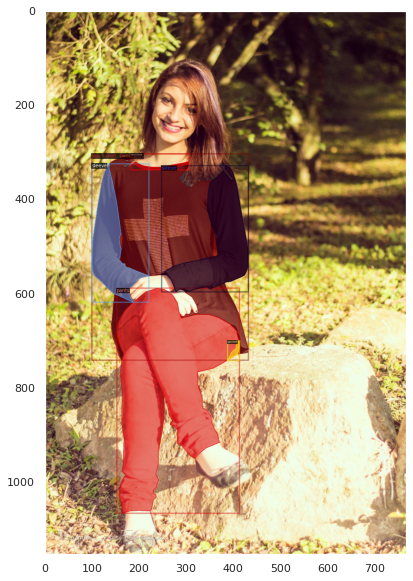

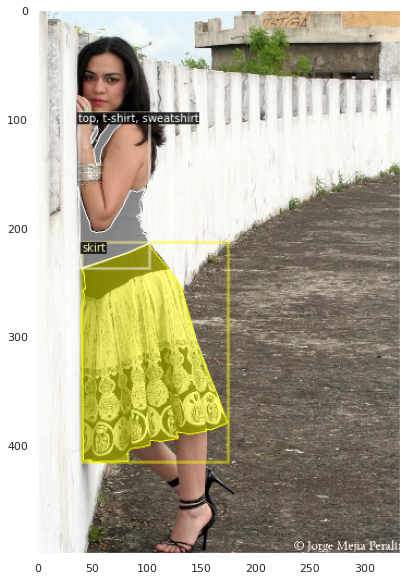

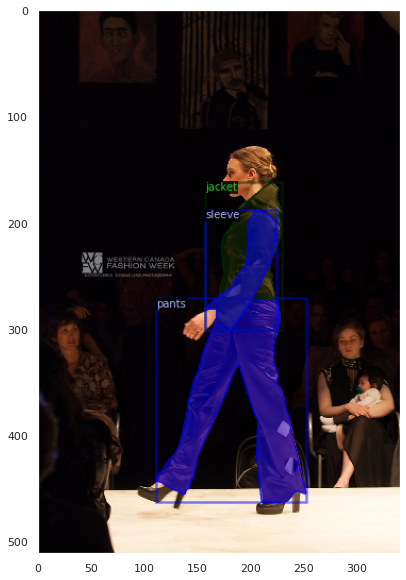

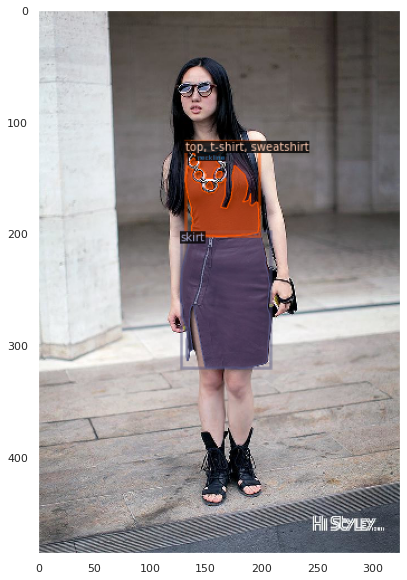

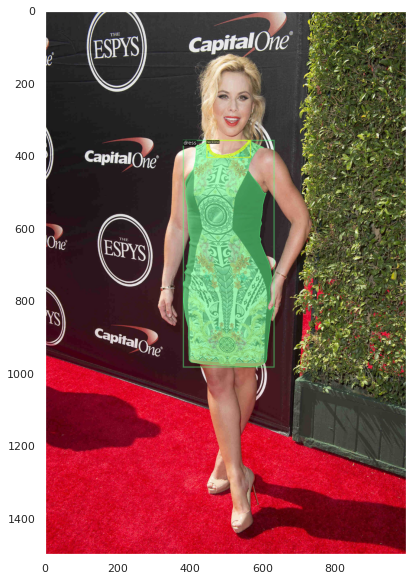

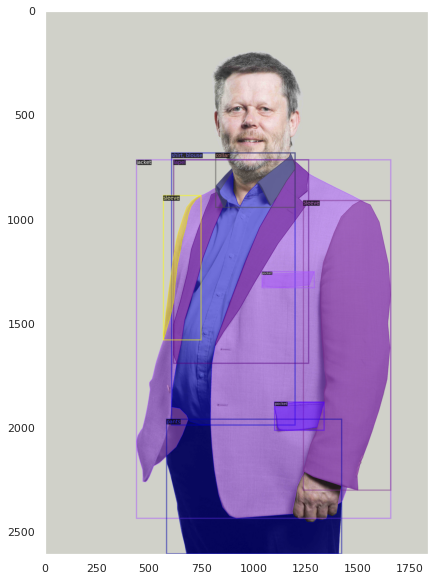

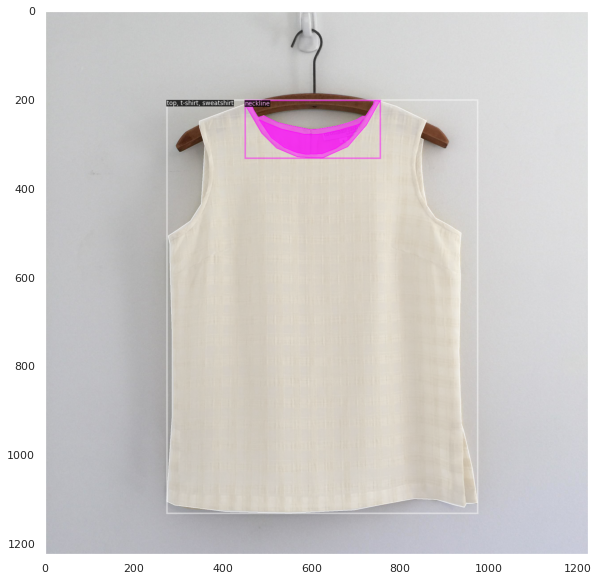

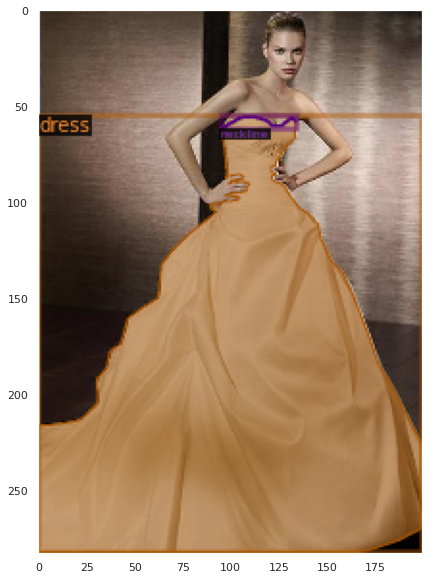

In [179]:
## Uncomment me b4 submission


# View some images + masks from the dataset
import random
for d in random.sample(fashion_dict, 8):
    plt.figure(figsize=(10,10))
    img = cv2.imread(d["file_name"])
#     if img:
    plt.grid(False)
    visualizer = Visualizer(img[:, :, ::-1], fashion_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::])
            

# 5. Train

## 5.1 Setup Config Files

In [180]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("sample_fashion_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmen tation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo

##### Input #####
# Set a smaller image size than default to avoid memory problems

# Size of the smallest side of the image during training
cfg.INPUT.MIN_SIZE_TRAIN = (40,)
# Maximum size of the side of the image during training
cfg.INPUT.MAX_SIZE_TRAIN = 60
# Size of the smallest side of the image during testing. Set to zero to disable resize in testing.
cfg.INPUT.MIN_SIZE_TEST = 40
# Maximum size of the side of the image during testing
cfg.INPUT.MAX_SIZE_TEST = 60

# Mask type
#cfg.INPUT.MASK_FORMAT = "bitmask"  # default: "polygon"


cfg.SOLVER.IMS_PER_BATCH = 10
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 50
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # default: 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 46  # 46 classes in iMaterialist (Categories)
cfg.MODEL.ROI_HEADS.NUM_ATTRIBUTES = 294  # 293 attributes in iMaterialist (Categories)

![image](https://user-images.githubusercontent.com/55464049/124000866-b48b6980-d9dc-11eb-8e7f-c5e8f0e57eff.png)


## 5.2 Run Training

In [181]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True) # Setup output dir

In [182]:
cfg.SOLVER.MAX_ITER = 7500
# cfg.MODEL.WEIGHTS = "../input/detectron2-imaterialist-weights/model_final.pth"
cfg.MODEL.WEIGHTS = '../input/updated-dataset-18-07/model_final_Jul18_15_23.pth' # Second Run

#trainer = DefaultTrainer(cfg) 
gc.collect()
trainer = FashionTrainer(cfg)
gc.collect()

100%|██████████| 150/150 [00:03<00:00, 44.18it/s]


513

In [183]:
trainer.resume_or_load(resume=True)

In [184]:
# Tried to see trainer's progress
# Hook class will enable us to run things between the iterations
# from detectron2.engine import HookBase

# class progressionHook(HookBase):
    
#     def after_step(self):
#         if self.trainer.iter % 50 == 0:
#             print(f"Hello at iteration {self.trainer.iter}!")
            

            
# progress_hook = progressionHook()
            
# trainer.register_hooks((progress_hook,))
    
    
# Tarin in steps: 
# start_iter = 0
# max_iter = cfg.SOLVER.MAX_ITER


# # hook.before_train()
# for iter in range(start_iter, max_iter):
# #     hook.before_step()
#     trainer.run_step()
#     progress_hook.after_step()
# iter += 1
# # hook.after_train()

* 

In [185]:
trainer.train()

AttributeError: Cannot find field 'gt_attributes' in the given Instances!

In [186]:
gc.collect()

4841

In [187]:
# Try to run the test from the trainer

# from detectron2.evaluation import COCOEvaluator, inference_on_dataset
# from detectron2.data import build_detection_test_loader
# from detectron2.checkpoint import DetectionCheckpointer

# cfg.MODEL.WEIGHTS = '../input/updated-dataset-18-07/model_final_Jul18_15_23.pth'
# # cfg.MODEL.WEIGHTS = "../input/detectron2-imaterialist-weights/model_final.pth"

# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
# cfg.DATASETS.TEST = ('sample_fashion_test',)

# model = FashionTrainer.build_model(cfg)

# DetectionCheckpointer(model, save_dir=cfg.OUTPUT_DIR).resume_or_load(
#     cfg.MODEL.WEIGHTS, resume=True
# )
# FashionTrainer.test(cfg, model)
# # evaluator = COCOEvaluator("sample_fashion_test", ("bbox", "segm"), False, output_dir="./output/")
# # val_loader = build_detection_test_loader(cfg, "sample_fashion_test")
# # print(inference_on_dataset(trainer.model, val_loader, evaluator))
# # another equivalent way to evaluate the model is to use `trainer.test`

Now, we perform inference with the trained model on the sample_fashion_test dataset. First, let's create a predictor using the model we just trained:

# 6. Test Trained Model

## 6.1 setup predictor

In [188]:
# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.WEIGHTS = "../input/updated-dataset-18-07/model_final_Jul18_15_23.pth"

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ('sample_fashion_test',)
predictor = DefaultPredictor(cfg)
gc.collect()

0

## 6.2 Predict over unseen test photos

In [189]:
from detectron2.utils.visualizer import ColorMode
plt.figure(figsize=(20,20))
for d in random.sample(fashion_dict, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=fashion_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    display(outputs['instances'])
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.grid(False)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    plt.show()
    plt.grid(False)
    plt.imshow(v.get_image())
    plt.show()
gc.collect()


INFERENCE cls 1 torch.Size([526, 47])
INFERENCE attr 1 torch.Size([526, 295])
INFERENCE cls 2 torch.Size([526, 47])
INFERENCE attr 2 torch.Size([526, 295])
INFERENCE cls 3 torch.Size([526, 46])
INFERENCE attr 3 torch.Size([526, 294])
INFERENCE cls 4 torch.Size([526, 46])
INFERENCE attr 4 torch.Size([526, 294])
INFERENCE cls mask 4 torch.Size([526, 46])
INFERENCE attr mask 4 torch.Size([526, 294])


IndexError: index is out of bounds for dimension with size 0

<Figure size 1440x1440 with 0 Axes>

In [190]:
image_path = '../input/imaterialist-fashion-2020-fgvc7/test/0046f98599f05fd7233973e430d6d04d.jpg'
im = cv2.imread(image_path)
# im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1],
               metadata=fashion_metadata,
               scale=0.8,
               instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
)
display(outputs['instances'])
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.grid(False)
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()
plt.grid(False)
plt.imshow(v.get_image())
plt.show()
gc.collect()

INFERENCE cls 1 torch.Size([520, 47])
INFERENCE attr 1 torch.Size([520, 295])
INFERENCE cls 2 torch.Size([520, 47])
INFERENCE attr 2 torch.Size([520, 295])
INFERENCE cls 3 torch.Size([520, 46])
INFERENCE attr 3 torch.Size([520, 294])
INFERENCE cls 4 torch.Size([520, 46])
INFERENCE attr 4 torch.Size([520, 294])
INFERENCE cls mask 4 torch.Size([520, 46])
INFERENCE attr mask 4 torch.Size([520, 294])


IndexError: index is out of bounds for dimension with size 0

## 6.3 Predict some images


In [ ]:
for image_name in tqdm(test_images):
    image_path = os.path.join(test_dir, image_name) # '../input/imaterialist-fashion-2020-fgvc7/test' # Instead of testDir
    if image_name == 'b1dfbc0da1055c82a599e6bb777bdb81.jpg':
        im = cv2.imread(image_path)
        plt.imshow(im)
        plt.grid(False)
        plt.title('Example image')
        break
    

In [ ]:
# Show different images at random
rows, cols = 3, 3
plt.figure(figsize=(20,20))

for i, d in enumerate(random.sample(fashion_dict, 9)):
    
    # Process image
    plt.subplot(rows, cols, i+1)

    im = cv2.imread(d["file_name"])
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    
    # Run through predictor
    outputs = predictor(im)
    
    # Visualize
    v = Visualizer(im[:, :, ::-1],
                   metadata=fashion_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.grid(False)
    plt.imshow(v.get_image()[:, :, ::-1])

plt.show()

## 6.4 Predict Test

In [191]:
predict_imgeid = []
# predict_mask = []
predict_rle = []
predict_classid = []
predict_attr = []
print(gc.collect())
limiter = 0 
_, _, test_images = next(os.walk(test_dir))

for image_name in tqdm(test_images):
#     limiter += 1 
#     if limiter == 500:
#         break
    image_path = os.path.join(test_dir, image_name)
    im = cv2.imread(image_path)
    outputs = predictor(im)
    # Extract the ID from the full path
    image_id = os.path.splitext(os.path.basename(image_path))[0]
    instances = outputs['instances']
    ############ DELETEME ############ 
#     print((instances.get_fields()))
#     break
    # Where is Attributes
    # pred_boxes
    # scores
    # pred_classes
    # pred_masks
    ############ DELETEME ############ 
    if len(instances.pred_classes) is 0:
        predict_imgeid.append(image_id)
#         predict_mask.append([])
        predict_rle.append(im.shape[0] * im.shape[1])
        predict_classid.append(-1)
        predict_attr.append('')
    else:
        for i, (mask, class_id) in enumerate(zip(instances.pred_masks, instances.pred_classes)):
            predict_imgeid.append(image_id)
#             predict_mask.append(mask)
            predict_rle.append(mask_to_rle(mask.to('cpu').numpy()))
            predict_classid.append(int(class_id.to('cpu')))
            predict_attr.append('')

torch.cuda.empty_cache()
gc.collect()


  0%|          | 0/3200 [00:00<?, ?it/s]

1827
INFERENCE cls 1 torch.Size([544, 47])
INFERENCE attr 1 torch.Size([544, 295])
INFERENCE cls 2 torch.Size([544, 47])
INFERENCE attr 2 torch.Size([544, 295])
INFERENCE cls 3 torch.Size([544, 46])
INFERENCE attr 3 torch.Size([544, 294])
INFERENCE cls 4 torch.Size([544, 46])
INFERENCE attr 4 torch.Size([544, 294])
INFERENCE cls mask 4 torch.Size([544, 46])
INFERENCE attr mask 4 torch.Size([544, 294])


TypeError: only integer tensors of a single element can be converted to an index

## 6.8 Export notebook as html

In [ ]:
%%shell
jupyter nbconvert --to html /content/SecondPracticeML.ipynb

## 6.5 MULTI-PROCESSING

In [ ]:
# import multiprocessing
# from joblib import Parallel, delayed

# num_cores = multiprocessing.cpu_count()
# inputs = myList

# if __name__ == "__main__":
#     processed_list = Parallel(n_jobs=num_cores)(delayed(my_function(i,parameters) 
#                                                         for i in inputs)

In [192]:
# import threading
# import time

# maxthreads = 4
# sema = threading.Semaphore(value=maxthreads)
# threads = list()
# lock = threading.Lock()

# predict_imgeid = []
# # predict_mask = []
# predict_rle = []
# predict_classid = []
# predict_attr = []
# print(gc.collect())

# def get_rle(mask):
#     rle = binary_mask_to_rle(mask)['counts']
#     result = ''
#     for r in rle:
#         result += f'{r} '
#     return result

# def process_image(data):
#     sema.acquire()
#     image_path = data
#     im = cv2.imread(image_path)
#     outputs = predictor(im)
#     # Extract the ID from the full path
#     image_id = os.path.splitext(os.path.basename(image_path))[0]
#     instances = outputs['instances']
#     lock.acquire()
#     if len(instances.pred_classes) is 0:
#         predict_imgeid.append(image_id)
#         predict_rle.append(get_rle(np.zeros_like(im)))
#         predict_classid.append(-1)
#         predict_attr.append([])
#     else:
#         for i, (mask, class_id) in enumerate(zip(outputs['instances'].pred_masks, outputs['instances'].pred_classes)):
#             predict_imgeid.append(image_id)
#             predict_rle.append(get_rle(mask.to('cpu').numpy()))
#             predict_classid.append(int(class_id.to('cpu')))
#             predict_attr.append([])
#     lock.release()
#     sema.release()

# for image_name in tqdm(test_images):
#     thread = threading.Thread(target=process_image,args=(os.path.join('../input/imaterialist-fashion-2020-fgvc7/test', image_name),))
#     threads.append(thread)
#     thread.start()

# for t in tqdm(threads):
#     t.join()


## 6.6 Create the submission file

In [193]:
pd.DataFrame({
    "ImageId":predict_imgeid,
    "EncodedPixels":predict_rle,
    "ClassId":predict_classid,
    "AttributesIds":predict_attr
}).to_csv("submission.csv", index=False)

## 6.7 Show the submission file

In [194]:
pd.read_csv('submission.csv').head()

Empty DataFrame
Columns: [ImageId, EncodedPixels, ClassId, AttributesIds]
Index: []